# <ins>K-mer Counting</ins>
Il seguente notebook fornisce un tutorial per l'esecuzione su Google Cloud Platform del progetto [k-merCounting](https://github.com/gaiaghi/k-merCounting), oltre a riportare gli output ottenuti dai test svolti.

## 1. Configurazione del progetto Google Cloud Platform (GCP)

### - Creazione di un nuovo progetto GCP
Tramite l'interfaccia di GCP preferita (console o linea di comando) [creare un nuovo progetto](https://cloud.google.com/resource-manager/docs/creating-managing-projects?hl=it).
*In questo notebook il progetto CGP creato è denominato `groovy-vector-406611`.*

### - Abilitazioni per il progetto
Configurare il progetto appena creato abilitando gli strumenti necessari:
*   [abilitare la fatturazione](https://cloud.google.com/billing/docs/how-to/modify-project?hl=it);
*   abilitare il servizio Cloud Storage;
*   abilitare il servizio Dataproc.








##2. Creazione delle variabili d'ambiente

*Questo passaggio è opzionale ma consigliato per la completa esecuzione di questo notebook.*

Installare il package di python `colab-env` che permette di gestire le variabili d'ambiente in Google Colab. L'esecuzione inizierà l'autenticazione tramite `google.colab.drive.mount` per avere accesso a Google Drive, dove verranno salvate le variabili.



In [17]:
!pip install colab-env -qU
import colab_env

  Preparing metadata (setup.py) ... done
Mounted at /content/gdrive


Aggiungere le variabili d'ambiente tramite `colab_env`.

Si specificano: il nome del progetto GCP precedentemente creato; la regione e la zona del cluster di utilizzo (maggiori informazioni alla pagina [Aree Geografiche e Zone - GCP](https://cloud.google.com/compute/docs/regions-zones?hl=it) ); il nome dei bucket per contenere dati e output di esecuzione, che devono essere univoci a livello globale ([Informazioni sui bucket Cloud Storage](https://cloud.google.com/storage/docs/buckets?hl=it#naming)).

In [18]:
colab_env.envvar_handler.add_env("PROJECT_ID", "groovy-vector-406611", overwrite=True)
colab_env.envvar_handler.add_env("CLUSTER_REGION", "europe-west4", overwrite=True)
colab_env.envvar_handler.add_env("CLUSTER_ZONE", "europe-west4-a", overwrite=True)
colab_env.envvar_handler.add_env("DATA_BKT", "gs://k-mercounting-sec-data/", overwrite=True)
colab_env.envvar_handler.add_env("OUTPUT_BKT", "gs://k-mercounting-sec-output/", overwrite=True)

In [19]:
# per visualizzare le variabili create
!more gdrive/My\ Drive/vars.env

COLAB_ENV = Active
PROJECT_ID = groovy-vector-406611
CLUSTER_REGION = europe-west4
CLUSTER_ZONE = europe-west4-a
DATA_BKT = gs://k-mercounting-sec-data/
OUTPUT_BKT = gs://k-mercounting-sec-output/


##3. Connessione a GCP tramite il notebook e recupero del progetto

Il codice del seguente blocco permette di accedere al proprio account di Google Cloud Platform, e di selezionare il progetto GCP precedentemente creato.

La selezione del progetto GCP viene effettuata tramite le variabili d'ambiente impostate come sopra. Se si è scelto di non eseguire i blocchi di codice per l'impostazione delle variabili d'ambiente tramite `colab_env` è necessario sostituirele chiamate ad `os.getenv` con le necessarie informazioni.



In [20]:
from google.colab import auth
import os

auth.authenticate_user()
idProject = os.getenv("PROJECT_ID")
!gcloud config set project {idProject}

Updated property [core/project].


Quindi, clonare il progetto K-merCounting.
Il progetto clonato potrà essere visualizzato nei file di Google Colab (icona della cartella del menù di destra).

In [ ]:
!git clone https://github.com/gaiaghi/k-merCounting

Cloning into 'k-merCounting'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 467 (delta 155), reused 197 (delta 68), pack-reused 174
Receiving objects: 100% (467/467), 46.30 MiB | 26.64 MiB/s, done.
Resolving deltas: 100% (229/229), done.



*La cartella* `data` *di k-merCounting contiene alcuni esempi di sequenze genomiche di piccole dimensioni che verranno utilizzate nelle esecuzioni. Per rendere completo il test, tuttavia, si consiglia di scaricare ulteriori sequenze genomiche, come suggerito nel seguente punto.*

##4. Creazione dei bucket e caricamento dei file

In questa fase verranno creati due bucket, per contenere i dati necessari all'esecuzione (il file jar del progetto e i file di input) e i dati di output.


Per le esecuzioni sul cloud verranno usate le sequenze genomiche ottenute dal [NCBI Reference Sequence Database](https://www.ncbi.nlm.nih.gov/refseq/) degli organismi *Saccharomyces cerevisiae* e *Drosophila melanogaster*, entrambi inclusi nel progetto github, oltre agli organismi *Serinus canaria* e *Mus musculus*.

 I file genomici degli ultimi due organismi elencati sono scaricabili ai seguenti link:
 - [Mus musculus](https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/Mus_musculus/reference/GCF_000001635.27_GRCm39/GCF_000001635.27_GRCm39_genomic.fna.gz);
 - [Serinus canaria](https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_other/Serinus_canaria/representative/GCF_022539315.1_serCan2020/GCF_022539315.1_serCan2020_genomic.fna.gz).


 Infine, creare il file jar del progetto k-merCounting (ad esempio, utilizzando il comando `sbt clean package`).



###- Creazione dei bucket
Creare due bucket di Google Cloud Storage (comando `mb`), rispettivamente per memorizzare il dataset e i risultati dell'algoritmo di K-mer Counting.


In [21]:
#copia dei nomi dei bucket dalle variabili di ambiente
data_name = os.getenv("DATA_BKT")
out_name = os.getenv("OUTPUT_BKT")

#creazione bucket
!gsutil mb -l EUROPE-WEST3 -b on {data_name}
!gsutil mb -l EUROPE-WEST3 -b on {out_name}

Creating gs://k-mercounting-sec-data/...
Creating gs://k-mercounting-sec-output/...


###- Caricamento dei file
Una volta creati i bucket copiare tutti i file genomici e il file jar nel bucket creato.

Nota: *Nell'esecuzione di questo notebook i file presenti nel progetto github sono stati copiati nel bucket GCP tramite linea di comando sotto riportata, mentre i due file genomici più grandi sono stati caricati tramite interfaccia di GCP.
È anche possibile caricare i file genomici di* Mus musculus *e* Serinus canaria *nei file del notebook, quindi copiare tutti i file tramite linea di comando aggiungendo le due linee lasciate commentate nel blocco di codice sottostante.*

In [ ]:
# copia dei file nel bucket dei dati
!gsutil cp ./k-merCounting/data/GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz {data_name}/
!gsutil cp ./k-merCounting/data/GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz {data_name}/
!gsutil cp kmercounting_2.12-0.1.0-SNAPSHOT11.jar {data_name}/
#!gsutil cp ./k-merCounting/data/GCF_000001405.40_GRCh38.p14_genomic.fna.gz {data_name}/
#!gsutil cp ./k-merCounting/data/GCF_022539315.1_serCan2020_genomic.fna.gz {data_name}/

Copying file://./k-merCounting/data/GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz [Content-Type=application/octet-stream]...
- [1 files][ 42.2 MiB/ 42.2 MiB]                                                
Operation completed over 1 objects/42.2 MiB.                                     
Copying file://./k-merCounting/data/GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz [Content-Type=application/octet-stream]...
- [1 files][  3.7 MiB/  3.7 MiB]                                                
Operation completed over 1 objects/3.7 MiB.                                      
Copying file://kmercounting_2.12-0.1.0-SNAPSHOT11.jar [Content-Type=application/java-archive]...
-
Operation completed over 1 objects/35.5 KiB.                                     


## 5. Creazione e impostazione dei cluster

Recuperare, per comodità, le variabili d'ambiente contenenti la regione e la zona dei cluster, che verranno utilizzate nella creazione dei cluster:

In [22]:
region = os.getenv("CLUSTER_REGION")
zone = os.getenv("CLUSTER_ZONE")

Seguono tutti i blocchi di codice per la creazione dei cluster utilizzati nell'esecuzione su GCP.

Si consiglia, tuttavia, di procedere nell'esecuzione di questo notebook nel seguente modo:
- creare un cluster
- eseguire i vari test progetto k-merCounting sul cluster creato;
- eliminare il cluster;
- passare al cluster successivo.


Si ricorda, infine, che il progetto k-merCounting è stato sviluppato in accordo con l'immagine cluster `2.1-debian11` (dettagli alla pagina [Versioni release 2.1.x](https://cloud.google.com/dataproc/docs/concepts/versioning/dataproc-release-2.1?hl=it)). In caso di impossibilità di esecuzione del codice su GCP, una possibile causa potrebbe essere l'aggiornamento dell'immagine di default dei cluster Dataproc ad una versione differente. In tal caso è possibile specificare l'immagine che si vuole utilizzare durante la creazione del cluster stesso ([Controllo delle versioni di Dataproc](https://cloud.google.com/dataproc/docs/concepts/versioning/overview?hl=it#selecting_versions)).


### i. Cluster a singolo nodo

In [41]:
!gcloud dataproc clusters create single-node-cluster \
  --region {region} \
  --zone {zone} \
  --single-node

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/c18e8130-972c-33e7-afc1-80b3fc385a41].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/single-node-cluster] Cluster placed in zone [europe-west4-a].


### ii. Cluster di tipo `n1-standard-4` con 2 worker

In [18]:
!gcloud dataproc clusters create two-4standard-cluster \
  --region {region} \
  --zone {zone} \
  --master-machine-type n1-standard-4\
  --master-boot-disk-size 500 \
  --worker-machine-type n1-standard-4 \
  --num-workers 2 \
  --worker-boot-disk-size 500

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/3b09f119-4953-3228-b586-ef7d475dc461].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/two-4standard-cluster] Cluster placed in zone [europe-west4-a].


###iii. Cluster di tipo `n1-standard-8` con 2 worker

In [33]:
!gcloud dataproc clusters create two-8standard-cluster \
  --region {region} \
  --zone {zone} \
  --master-machine-type n1-standard-8\
  --master-boot-disk-size 500 \
  --worker-machine-type n1-standard-8 \
  --num-workers 2 \
  --worker-boot-disk-size 500

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/74dc5a83-5f9c-3eec-95ed-130ac472127b].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/two-8standard-cluster] Cluster placed in zone [europe-west4-a].


###iv. Cluster di tipo `n1-standard-4` con 3 worker

In [30]:
!gcloud dataproc clusters create three-4standard-cluster \
  --region {region} \
  --zone {zone} \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-size 500 \
  --worker-machine-type n1-standard-4 \
  --num-workers 3 \
  --worker-boot-disk-size 500

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/c969ec09-cbed-313b-8d49-113124efb253].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/three-4standard-cluster] Cluster placed in zone [europe-west4-a].


###v. Cluster di tipo `n1-standard-4` con 4 worker

In [26]:
!gcloud dataproc clusters create four-4standard-cluster \
  --region {region} \
  --zone {zone} \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-size 500 \
  --worker-machine-type n1-standard-4 \
  --num-workers 4 \
  --worker-boot-disk-size 500

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/66746607-66e6-3c6a-940e-e719c2de4e94].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/four-4standard-cluster] Cluster placed in zone [europe-west4-a].


###vi. Cluster di tipo `n1-standard-4` con 5 worker

In [43]:
!gcloud dataproc clusters create five-4standard-cluster \
  --region {region} \
  --zone {zone} \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-size 500 \
  --worker-machine-type n1-standard-4 \
  --num-workers 5 \
  --worker-boot-disk-size 500

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/ceeddbee-6bf1-383a-a099-071e78c55e03].

Created [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/five-4standard-cluster] Cluster placed in zone [europe-west4-a].


---

## 6. Esecuzione sui cluster

###i. Esecuzione **distribuita** sul file genomico *Saccharomyces cerevisiae*

Di seguito sono presenti le esecuzioni dell'algoritmo distribuito sul cluster a **singolo nodo** e sul cluster `n1-standard-4` con **2 worker** e **4 worker**   (come riportato nei commenti delle celle di codice) ed i seguenti parametri:


*   valore di lunghezza delle sequenze kmer `k=3`;
*   modalità di conteggio non canonico (*`non-canonical` counting*).



> La lunghezza del genoma del Saccharomyces cerevisiae è di 12.1 Mb (dove Mb significa *megabasi*, ovvero un milione di basi azotate).




In [ ]:
# cluster a singolo nodo e parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"k-merCounting_2-12j.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "distributed" {os.getenv("OUTPUT_BKT")}"single-node-d"

Job [52df1baca57246f58ce6255cdeefdb4c] submitted.
Waiting for job output...
23/11/30 13:02:30 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/30 13:02:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/30 13:02:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/30 13:02:30 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/11/30 13:02:31 INFO org.sparkproject.jetty.util.log: Logging initialized @6771ms to org.sparkproject.jetty.util.log.Slf4jLog
23/11/30 13:02:31 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/11/30 13:02:31 INFO org.sparkproject.jetty.server.Server: Started @6964ms
23/11/30 13:02:31 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@3162743f{HTTP/1.1, (http/1.1)}{0.0.0.0:37199}
23/11/30 13:02:32 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 2 workers e parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "distributed" {os.getenv("OUTPUT_BKT")}"two4std-sc-dist"

Job [e818077d02f94741a634b2466e62552c] submitted.
Waiting for job output...
23/12/29 10:37:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 10:37:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 10:37:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 10:37:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 10:37:36 INFO org.sparkproject.jetty.util.log: Logging initialized @4172ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 10:37:36 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 10:37:36 INFO org.sparkproject.jetty.server.Server: Started @4285ms
23/12/29 10:37:36 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:42837}
23/12/29 10:37:37 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 4 workers e parallelismo = 8
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "8" "distributed" {os.getenv("OUTPUT_BKT")}"four4std-sc-dist-k3-p8"

Job [010635cc6eb0492db7fbed5ca5f82ea8] submitted.
Waiting for job output...
23/12/29 18:14:48 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 18:14:48 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 18:14:48 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 18:14:48 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 18:14:48 INFO org.sparkproject.jetty.util.log: Logging initialized @4270ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 18:14:49 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 18:14:49 INFO org.sparkproject.jetty.server.Server: Started @4400ms
23/12/29 18:14:49 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:38757}
23/12/29 18:14:49 INFO org.apache.hadoop.yarn.client.RMPro

###ii. Esecuzione **di libreria** sul file genomico *Saccharomyces Cerevisiae*

Di seguito sono presenti le esecuzioni dell'**algoritmo di libreria** sul cluster a **singolo nodo** e sul cluster `n1-standard-4` con **2 worker** e **4 worker** (come riportato nei commenti delle celle di codice) ed i seguenti parametri:


*   valore di lunghezza delle sequenze kmer `k=3`;
*   modalità di conteggio non canonico (*`non-canonical` counting*).



In [ ]:
# cluster a singolo nodo con parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"k-merCounting_2-12j.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "library" {os.getenv("OUTPUT_BKT")}"single-node-d-lib"

Job [169b1568fccb44e285d8a40481139709] submitted.
Waiting for job output...
23/11/30 13:10:15 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/30 13:10:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/30 13:10:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/30 13:10:15 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/11/30 13:10:16 INFO org.sparkproject.jetty.util.log: Logging initialized @3862ms to org.sparkproject.jetty.util.log.Slf4jLog
23/11/30 13:10:16 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/11/30 13:10:16 INFO org.sparkproject.jetty.server.Server: Started @3974ms
23/11/30 13:10:16 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@1bf04007{HTTP/1.1, (http/1.1)}{0.0.0.0:43533}
23/11/30 13:10:16 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 2 workers e parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "library" {os.getenv("OUTPUT_BKT")}"two-4standard-sc-k3-library"

Job [2e883cb0fcfe44d0890a8ca1f1a4d797] submitted.
Waiting for job output...
23/12/31 13:44:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/31 13:44:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/31 13:44:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/31 13:44:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/31 13:44:40 INFO org.sparkproject.jetty.util.log: Logging initialized @4870ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/31 13:44:40 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/31 13:44:40 INFO org.sparkproject.jetty.server.Server: Started @4990ms
23/12/31 13:44:40 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:41653}
23/12/31 13:44:41 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 4 workers e parallelismo = 8
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "8" "library" {os.getenv("OUTPUT_BKT")}"four4std-sc-libr-k3-p8"

Job [2b05028d259941f0849fe7118e4d1f97] submitted.
Waiting for job output...
23/12/29 17:53:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 17:53:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 17:53:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 17:53:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 17:53:13 INFO org.sparkproject.jetty.util.log: Logging initialized @4140ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 17:53:13 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 17:53:13 INFO org.sparkproject.jetty.server.Server: Started @4288ms
23/12/29 17:53:13 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:46041}
23/12/29 17:53:14 INFO org.apache.hadoop.yarn.client.RMPro

###iii. Esecuzione **parallela** sul file genomico *Saccharomyces Cerevisiae*

Di seguito sono presenti le esecuzioni dell'**algoritmo parallelo** sul cluster a **singolo nodo** e sul cluster `n1-standard-4` con **2 worker** e **4 workers**  (come riportato nei commenti delle celle di codice) ed i seguenti parametri:


*   valore di lunghezza delle sequenze kmer `k=3`;
*   modalità di conteggio non canonico (*`non-canonical` counting*).



In [22]:
# cluster a singolo nodo e parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=single-node-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "parallel" {os.getenv("OUTPUT_BKT")}"single-sc-par-k3-p4"

Job [ce1c7d947fe94e458b2408782033b596] submitted.
Waiting for job output...
23/12/29 18:04:41 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 18:04:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 18:04:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 18:04:41 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 18:04:41 INFO org.sparkproject.jetty.util.log: Logging initialized @4342ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 18:04:41 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 18:04:41 INFO org.sparkproject.jetty.server.Server: Started @4463ms
23/12/29 18:04:41 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:34871}
23/12/29 18:04:42 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 2 worker e parallelismo = 4
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "4" "parallel" {os.getenv("OUTPUT_BKT")}"two-4standard-sc-k3-parallel"

Job [8b1d466a44d54cd1a8bb1b201388b590] submitted.
Waiting for job output...
23/12/31 13:52:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/31 13:52:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/31 13:52:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/31 13:52:05 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/31 13:52:05 INFO org.sparkproject.jetty.util.log: Logging initialized @3529ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/31 13:52:06 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/31 13:52:06 INFO org.sparkproject.jetty.server.Server: Started @3640ms
23/12/31 13:52:06 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:33187}
23/12/31 13:52:06 INFO org.apache.hadoop.yarn.client.RMPro

In [20]:
# cluster n1-standard-4 con 4 worker e parallelismo 8
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000146045.2_R64_genomic_Saccharomyces_cerevisiae.fna.gz" "3" "non-canonical" "8" "parallel" {os.getenv("OUTPUT_BKT")}"four4std-sc-par-k3-p8"

Job [1ef6be3585e34505b2338a381dd4c4d2] submitted.
Waiting for job output...
23/12/29 18:00:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 18:00:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 18:00:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 18:00:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 18:00:40 INFO org.sparkproject.jetty.util.log: Logging initialized @4492ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 18:00:40 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 18:00:40 INFO org.sparkproject.jetty.server.Server: Started @4654ms
23/12/29 18:00:40 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:33453}
23/12/29 18:00:41 INFO org.apache.hadoop.yarn.client.RMPro

###iv. Esecuzione **distribuita** sul file genomico *Drosophila melanogaster*

Di seguito sono presenti le esecuzioni dell'**algoritmo distribuito** sui seguenti cluster:

*   cluster `n1-standard-4` con **2 worker**;
*   cluster `n1-standard-4` con **3 workers**;
*   cluster `n1-standard-4` con **4 workers**;
*   cluster `n1-standard-4` con **5 workers**;
*   cluster `n1-standard-8` con **2 workers**.


Per ogni prova effettuata, il parametro che indica la modalità di conteggio sarà `both`, che permette di effettuare entrambi i conteggi (canonico e non canonico).

Oltre al tipo di cluster utilizzato, le esecuzioni differiscono dai valori dei parametri di lunghezza delle sequenze kmer (`k`) e dal parametro di parallelizzazione (`p`), come verrà indicato nei commenti dei blocchi di codice che seguono.




> La lunghezza del genoma di Drosophila melanogaster è di 143.7 Mb (*megabasi*).



In [ ]:
# cluster n1-standard-4 con 2 worker, k=4, p=16
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"k-merCounting_2-12j.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"two-4standard-d"

Job [89dd2b76e73f4516bf08a1fed7245c3a] submitted.
Waiting for job output...
23/11/30 13:29:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/30 13:29:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/30 13:29:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/30 13:29:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/11/30 13:29:40 INFO org.sparkproject.jetty.util.log: Logging initialized @4029ms to org.sparkproject.jetty.util.log.Slf4jLog
23/11/30 13:29:40 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/11/30 13:29:40 INFO org.sparkproject.jetty.server.Server: Started @4152ms
23/11/30 13:29:40 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@3162743f{HTTP/1.1, (http/1.1)}{0.0.0.0:39375}
23/11/30 13:29:41 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 3 worker, k=4, p=16
!gcloud dataproc jobs submit spark \
    --cluster=three-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"three-4standard-d"

Job [9f3110b9f26348da870e75925a9daba0] submitted.
Waiting for job output...
23/12/29 20:43:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 20:43:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 20:43:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 20:43:14 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 20:43:14 INFO org.sparkproject.jetty.util.log: Logging initialized @4004ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 20:43:14 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 20:43:14 INFO org.sparkproject.jetty.server.Server: Started @4130ms
23/12/29 20:43:14 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:38251}
23/12/29 20:43:15 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 4 worker, k=4, p=16
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"four-4standard-d"

Job [de06a569e30d49dea8013f824ed9bd8a] submitted.
Waiting for job output...
23/12/01 10:05:37 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/01 10:05:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/01 10:05:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/01 10:05:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/01 10:05:38 INFO org.sparkproject.jetty.util.log: Logging initialized @4898ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/01 10:05:38 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/01 10:05:38 INFO org.sparkproject.jetty.server.Server: Started @5047ms
23/12/01 10:05:38 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@1718698d{HTTP/1.1, (http/1.1)}{0.0.0.0:39213}
23/12/01 10:05:39 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 5 worker, k=4, p=32
!gcloud dataproc jobs submit spark \
    --cluster=five-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.1-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "4" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"five-4standard-d-both1-1"

Job [a33383e502004204b4d9670aad858537] submitted.
Waiting for job output...
23/12/01 17:59:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/01 17:59:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/01 17:59:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/01 17:59:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/01 17:59:13 INFO org.sparkproject.jetty.util.log: Logging initialized @3940ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/01 17:59:13 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/01 17:59:13 INFO org.sparkproject.jetty.server.Server: Started @4054ms
23/12/01 17:59:13 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:45965}
23/12/01 17:59:14 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-8 con 2 worker, k= 4, p = 32
!gcloud dataproc jobs submit spark \
    --cluster=two-8standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "4" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"two-8standard32-d"

Job [22a84141d59240ff9b0d862a0bbdf58e] submitted.
Waiting for job output...
23/12/29 10:48:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/29 10:48:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/29 10:48:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/29 10:48:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/29 10:48:39 INFO org.sparkproject.jetty.util.log: Logging initialized @3499ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/29 10:48:39 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/29 10:48:39 INFO org.sparkproject.jetty.server.Server: Started @3598ms
23/12/29 10:48:39 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@6f0cb5a1{HTTP/1.1, (http/1.1)}{0.0.0.0:46641}
23/12/29 10:48:40 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# custer n1-standard-8 con 2 workers, k=8, p=32
!gcloud dataproc jobs submit spark \
    --cluster=two-8standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "8" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"two-8standard-d-k8"

Job [235ad8b751234ffdb9f5c186c5a5481a] submitted.
Waiting for job output...
23/12/04 23:27:31 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/04 23:27:31 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/04 23:27:31 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/04 23:27:31 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/04 23:27:31 INFO org.sparkproject.jetty.util.log: Logging initialized @3127ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/04 23:27:31 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/04 23:27:31 INFO org.sparkproject.jetty.server.Server: Started @3226ms
23/12/04 23:27:31 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@6f0cb5a1{HTTP/1.1, (http/1.1)}{0.0.0.0:36377}
23/12/04 23:27:32 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 2 workers, k=8, p=32
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "8" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"two-4standard-mm-k8-p32"

Job [d2aa476ec70549829c6426f026824683] submitted.
Waiting for job output...
24/01/02 21:10:19 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/01/02 21:10:19 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/01/02 21:10:19 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/01/02 21:10:20 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/01/02 21:10:20 INFO org.sparkproject.jetty.util.log: Logging initialized @3825ms to org.sparkproject.jetty.util.log.Slf4jLog
24/01/02 21:10:20 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
24/01/02 21:10:20 INFO org.sparkproject.jetty.server.Server: Started @3959ms
24/01/02 21:10:20 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:37105}
24/01/02 21:10:21 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 3 workers, k=8, p=32
!gcloud dataproc jobs submit spark \
    --cluster=three-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "8" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"three-4standard-mmk4p32"

Job [84a70118b9374be2b57a60529b112d02] submitted.
Waiting for job output...
24/01/02 21:41:33 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/01/02 21:41:33 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/01/02 21:41:33 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/01/02 21:41:33 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/01/02 21:41:34 INFO org.sparkproject.jetty.util.log: Logging initialized @3683ms to org.sparkproject.jetty.util.log.Slf4jLog
24/01/02 21:41:34 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
24/01/02 21:41:34 INFO org.sparkproject.jetty.server.Server: Started @3801ms
24/01/02 21:41:34 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@62b7fa19{HTTP/1.1, (http/1.1)}{0.0.0.0:37503}
24/01/02 21:41:35 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 4 workers, k=8, p=16
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "8" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"four-4standard-d-k8"

Job [ebf1f78fc412406cb9a1bcc04f15fe96] submitted.
Waiting for job output...
23/12/05 00:44:17 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/05 00:44:17 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/05 00:44:18 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/05 00:44:18 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/05 00:44:18 INFO org.sparkproject.jetty.util.log: Logging initialized @4486ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/05 00:44:18 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/05 00:44:18 INFO org.sparkproject.jetty.server.Server: Started @4609ms
23/12/05 00:44:18 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:40433}
23/12/05 00:44:19 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 5 workers, k=8, p=16
!gcloud dataproc jobs submit spark \
    --cluster=five-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001215.4_Release_6_plus_ISO1_MT_genomic_drosophila_melanogaster.fna.gz" "8" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"five-4standard-d-k8"

Job [1a673653a9da4372a527d6c4b574156c] submitted.
Waiting for job output...
23/12/05 00:57:43 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/05 00:57:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/05 00:57:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/05 00:57:43 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/05 00:57:44 INFO org.sparkproject.jetty.util.log: Logging initialized @4767ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/05 00:57:44 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/05 00:57:44 INFO org.sparkproject.jetty.server.Server: Started @4946ms
23/12/05 00:57:44 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:42633}
23/12/05 00:57:45 INFO org.apache.hadoop.yarn.client.RMPro

###v. Esecuzione **distribuita** sul file genomico *Serinus canaria*

Di seguito è presente l'esecuzione dell'algoritmo distribuito sul cluster `n1-standard-4` con **4 worker** per il conteggio dei kmer canonici e non canonici (parametro *counting type* = `both`) di lunghezza `k=4`.



> La lunghezza del genoma del Serinus canaria è di 	1.1 Gb (*gigabasi*).



In [ ]:
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_022539315.1_serCan2020_genomic.fna.gz" "4" "both" "32" "distributed" {os.getenv("OUTPUT_BKT")}"four-4standard-sc"

Job [1c2325a7c1384780b17b7f48ea6a6ae2] submitted.
Waiting for job output...
23/12/31 15:53:53 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/31 15:53:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/31 15:53:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/31 15:53:54 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/31 15:53:54 INFO org.sparkproject.jetty.util.log: Logging initialized @5001ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/31 15:53:54 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/31 15:53:54 INFO org.sparkproject.jetty.server.Server: Started @5152ms
23/12/31 15:53:54 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:36581}
23/12/31 15:53:55 INFO org.apache.hadoop.yarn.client.RMPro

###vi. Esecuzione **distribuita** sul file genomico *Mus musculus*

Di seguito sono presenti le esecuzioni dell'**algoritmo distribuito** sul cluster `n1-standard-4` con un numero variabile di worker (**da 2 a 5 worker**).

Per ogni prova effettuata, il parametro che indica la modalità di conteggio sarà `both`, che permette di effettuare entrambi i conteggi (canonico e non canonico) delle sequenze kmer di lunghezza `k=4`.

La lunghezza totale del genoma del Mus musculus è di 2.7Gb (*gigabasi*).

In [ ]:
# cluster n1-standard-4 con 2 workers
!gcloud dataproc jobs submit spark \
    --cluster=two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001635.27_GRCm39_genomic.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"two-4standard-mm"

In [ ]:
# cluster n1-standard-4 con 3 workers
!gcloud dataproc jobs submit spark \
    --cluster=three-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001635.27_GRCm39_genomic.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"three-4standard-mm"

Job [fbc318a8801c4b46adea553b621707f0] submitted.
Waiting for job output...
23/12/30 12:25:57 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/30 12:25:57 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/30 12:25:57 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/30 12:25:57 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/30 12:25:57 INFO org.sparkproject.jetty.util.log: Logging initialized @3846ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/30 12:25:57 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/30 12:25:57 INFO org.sparkproject.jetty.server.Server: Started @3955ms
23/12/30 12:25:57 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:44491}
23/12/30 12:25:58 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 4 workers
!gcloud dataproc jobs submit spark \
    --cluster=four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001635.27_GRCm39_genomic.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"four-4standard-mm"

Job [988846c4e4924cd3a2f2d4bdaf9f5bf4] submitted.
Waiting for job output...
23/12/06 08:23:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/06 08:23:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/06 08:23:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/06 08:23:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/06 08:23:37 INFO org.sparkproject.jetty.util.log: Logging initialized @4204ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/06 08:23:37 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/06 08:23:37 INFO org.sparkproject.jetty.server.Server: Started @4320ms
23/12/06 08:23:37 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:37967}
23/12/06 08:23:38 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
# cluster n1-standard-4 con 5 workers
!gcloud dataproc jobs submit spark \
    --cluster=five-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")} \
    --jar={os.getenv("DATA_BKT")}"kmercounting_2.12-0.1.0-SNAPSHOT11.jar" \
    -- "yarn" {os.getenv("DATA_BKT")}"GCF_000001635.27_GRCm39_genomic.fna.gz" "4" "both" "16" "distributed" {os.getenv("OUTPUT_BKT")}"five-4standard-mm"

Job [fba266b0cd1143c997d1877b26069c13] submitted.
Waiting for job output...
23/12/05 19:42:22 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/05 19:42:22 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/05 19:42:22 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/05 19:42:22 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/12/05 19:42:22 INFO org.sparkproject.jetty.util.log: Logging initialized @4354ms to org.sparkproject.jetty.util.log.Slf4jLog
23/12/05 19:42:22 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_392-b08
23/12/05 19:42:22 INFO org.sparkproject.jetty.server.Server: Started @4473ms
23/12/05 19:42:22 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@25b5c5e3{HTTP/1.1, (http/1.1)}{0.0.0.0:35529}
23/12/05 19:42:23 INFO org.apache.hadoop.yarn.client.RMPro

---

## 7. Eliminazione dei cluster

Conclusa l'esecuzione degli algoritmi procedere con l'eliminazione dei cluster creati.

In [42]:
!gcloud dataproc clusters delete single-node-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'single-node-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/ca3f9247-4ee9-3691-acb8-9b953c9c73e2].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/single-node-cluster].


In [21]:
!gcloud dataproc clusters delete two-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'two-4standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/3aaacb6b-b5fe-35e5-9920-4458a761f8b6].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/two-4standard-cluster].


In [35]:
!gcloud dataproc clusters delete two-8standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'two-8standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/e68985ab-014f-37c8-9066-d1c324a67d4a].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/two-8standard-cluster].


In [31]:
!gcloud dataproc clusters delete three-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'three-4standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/ffa762ca-6ff6-391f-bb1e-8f783fbaa41f].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/three-4standard-cluster].


In [29]:
!gcloud dataproc clusters delete four-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'four-4standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/625b14a9-5415-3f97-b863-29c969255469].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/four-4standard-cluster].


In [53]:
!gcloud dataproc clusters delete five-4standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'five-4standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/a0a39101-1daa-3c64-982f-b96341db0d1e].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/five-4standard-cluster].


In [ ]:
!gcloud dataproc clusters delete four-8standard-cluster \
    --region={os.getenv("CLUSTER_REGION")}

The cluster 'four-8standard-cluster' and all attached disks will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/groovy-vector-406611/regions/europe-west4/operations/55d58c13-3adf-34b8-a2ef-ddca419332f2].
Deleted [https://dataproc.googleapis.com/v1/projects/groovy-vector-406611/regions/europe-west4/clusters/four-8standard-cluster].


Per controllare di aver eliminato tutti i cluster creati è possibile eseguire la seguente riga di codice, che mostra i cluster attivi nella regione specificata:

In [ ]:
!gcloud dataproc clusters list --region {region}

## 8. Copia dei risultati ed eliminazione dei bucket

Prima dell'eliminazione dei bucket, copiare in locale i risultati delle esecuzioni del cloud. Si può procedere tramite l'interfaccia grafica di GCP, oppure tramite il notebook, eseguendo la seguente riga di codice:

In [ ]:
!gsutil -m cp -r "gs://k-mercounting-sec-output" .

Quindi, eliminare i bucket:

In [ ]:
!gcloud alpha storage rm --recursive {os.getenv("DATA_BKT")}

In [ ]:
!gcloud alpha storage rm --recursive {os.getenv("OUTPUT_BKT")}

## 9. Analisi dei risultati

Per concludere, si analizzano i risultati delle esecuzioni cloud.

Supponendo di aver eseguito le prove riportate precedentemente ed aver copiato i risultati come indicato nella sezione 8, sarà possibile visualizzare i file di output nella cartella "k-mercounting-sec-output" del notebook.

Per comodità nella creazione dei grafici, copiare i file in quattro differenti cartelle:

In [16]:
# creazione delle cartelle per i grafici
!mkdir plot
!mkdir plot/algorithms
!mkdir plot/strong
!mkdir plot/vertical
!mkdir plot/weak

In [ ]:
# creazione sottocartelle e copia dei file per il confronto degli algoritmi
!mkdir plot/algorithms/dist
!mkdir plot/algorithms/lib
!mkdir plot/algorithms/par

!cp k-mercounting-sec-output/four4std-sc-dist-k3-p8/four4std-sc-dist-k3-p8_part-00000 plot/algorithms/dist
!cp k-mercounting-sec-output/single-node-d/single-node-d_part-00000 plot/algorithms/dist
!cp k-mercounting-sec-output/two4std-sc-dist/two4std-sc-dist_part-00000 plot/algorithms/dist

!cp k-mercounting-sec-output/four4std-sc-libr-k3-p8/four4std-sc-libr-k3-p8_part-00000 plot/algorithms/lib
!cp k-mercounting-sec-output/single-node-d-lib/single-node-d-lib_part-00000 plot/algorithms/lib
!cp k-mercounting-sec-output/two-4standard-sc-k3-library/two-4standard-sc-k3-library_part-00000 plot/algorithms/lib

!cp k-mercounting-sec-output/four4std-sc-par-k3-p8/four4std-sc-par-k3-p8_part-00000 plot/algorithms/par
!cp k-mercounting-sec-output/single-node-d-lib/single-node-d-lib_part-00000 plot/algorithms/par
!cp k-mercounting-sec-output/two-4standard-sc-k3-parallel/two-4standard-sc-k3-parallel_part-00000 plot/algorithms/par

In [20]:
# creazione sottocartelle e copia dei file per strong scaling
!mkdir plot/strong/dr4
!mkdir plot/strong/dr8
!mkdir plot/strong/mm

!cp k-mercounting-sec-output/five-4standard-d-both1-1/five-4standard-d-both1-1_part-00000 plot/strong/dr4
!cp k-mercounting-sec-output/four-4standard-d/four-4standard-d_part-00000 plot/strong/dr4
!cp k-mercounting-sec-output/three-4standard-d/three-4standard-d_part-00000 plot/strong/dr4
!cp k-mercounting-sec-output/two-4standard-d/two-4standard-d_part-00000 plot/strong/dr4


!cp k-mercounting-sec-output/five-4standard-d-k8/five-4standard-d-k8_part-00000 plot/strong/dr8
!cp k-mercounting-sec-output/four-4standard-d-k8/four-4standard-d-k8_part-00000 plot/strong/dr8
!cp k-mercounting-sec-output/three-4standard-mmk4p32/three-4standard-mmk4p32_part-00000 plot/strong/dr8
!cp k-mercounting-sec-output/two-4standard-mm-k8-p32/two-4standard-mm-k8-p32_part-00000 plot/strong/dr8


!cp k-mercounting-sec-output/five-4standard-mm/five-4standard-mm_part-00000 plot/strong/mm
!cp k-mercounting-sec-output/four-4standard-mm/four-4standard-mm_part-00000 plot/strong/mm
!cp k-mercounting-sec-output/three-4standard-mm/three-4standard-mm_part-00000 plot/strong/mm
!cp k-mercounting-sec-output/two-4standard-mm/two-4standard-mm_part-00000 plot/strong/mm

In [21]:
# creazione sottocartelle e copia dei file per il vertical scaling
!mkdir plot/vertical/dr4
!mkdir plot/vertical/dr8

!cp k-mercounting-sec-output/two-4standard-d/two-4standard-d_part-0000 plot/vertical/dr4
!cp k-mercounting-sec-output/two-8standard32-d/two-8standard32-d_part-00000 plot/vertical/dr4

!cp k-mercounting-sec-output/two-4standard-mm-k8-p32/two-4standard-mm-k8-p32_part-00000 plot/vertical/dr8
!cp k-mercounting-sec-output/two-8standard-d/two-8standard-d-k8_part-00000 plot/vertical/dr8

In [ ]:
# creazione sottocartelle e copia dei file per il weak scaling
!cp k-mercounting-sec-output/five-4standard-mm/five-4standard-mm_part-00000 plot/weak
!cp k-mercounting-sec-output/four-4standard-sc/four-4standard-sc_part-00000 plot/weak
!cp k-mercounting-sec-output/three-4standard-d/three-4standard-d_part-00000 plot/weak
!cp k-mercounting-sec-output/two4std-sc-dist/two4std-sc-dist_part-00000 plot/weak

### i. Creazione del grafico per il **confronto degli algoritmi**

I tre algoritmi (algoritmo distribuito, di libreria e parallelo), vengono messi a confronto con le prove eseguite sul genoma del Saccharomyces cerevisiae. In particolare, le prove sono state eseguite per una **conta *non canonica*** dei ***k-mer* di lunghezza 3**, sui seguenti tre cluster:

*   cluster a singolo nodo;
*   cluster `n1-standard-4` con 2 worker;
*   cluster `n1-standard-4` con 4 worker.



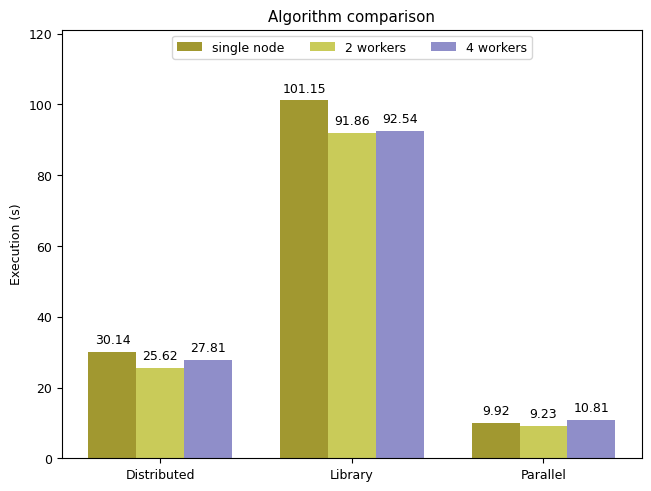

In [75]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os

dir_dist = 'plot/algorithms/dist'
dir_par = 'plot/algorithms/par'
dir_lib = 'plot/algorithms/lib'

algorithms = ("Distributed", "Library", "Parallel")
alg_stats = {"single node":(), "2 workers":(), "4 workers":()}
times = {'Distributed':[], 'Library':[], 'Parallel':[]}

for file in os.listdir(dir_dist):
  file_path = dir_dist + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Distributed'].append(exeTime)

for file in os.listdir(dir_lib):
  file_path = dir_lib + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Library'].append(exeTime)

for file in os.listdir(dir_par):
  file_path = dir_par + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Parallel'].append(exeTime)

alg_stats["4 workers"] = (times["Distributed"][0],times["Library"][0],times["Parallel"][0])
alg_stats["single node"] = (times["Distributed"][1],times["Library"][1],times["Parallel"][1])
alg_stats["2 workers"] = (times["Distributed"][2],times["Library"][2],times["Parallel"][2])
# colors = {"4 workers":'#8cc1a7', "2 workers":'#5c82a6', "single node":'#e5b9b0'}
colors = {"5 workers":'#66669e', "4 workers":'#8f8ec9',"3 workers":'#babae0', "2 workers":'#c9cb59', "single node":'#a19830'}


x = np.arange(len(algorithms))  #label
width = 0.25
multiplier = 0


fig, ax = plt.subplots(layout='constrained')
plt.rcParams.update({'font.size': 9})

for attribute, measurement in alg_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
    ax.bar_label(rects, padding=4, fmt='%.2f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution (s)')
ax.set_title('Algorithm comparison')
ax.set_xticks(x + width, algorithms)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, max(alg_stats["single node"])+20)

plt.show()


Da questo confronto è evidente come le versioni distribuita e parallela dell'algoritmo siano notevolmente più efficienti della versione di libreria.

Come prevedibile, la versione parallela non mostra nessun significativo miglioramento delle prestazioni dal passaggio a cluster di più nodi rispetto al caso di singolo nodo, non potendo sfruttare le potenzialità del cluster distribuito.

Un leggero miglioramento nel passaggio da single-node a cluster con 2 worker è visibile nel caso distribuito e di libreria, sebbene lo speed-up sia minimo, e non si possa estendere al successivo passaggio al cluster con 4 worker.
Questo può essere spiegato considerando le dimensioni del file genomico in esame: siccome il file del Saccharomyces cerevisiae ha dimensioni ridotte, cluster di eccessive dimensioni (4 worker, in questo caso) introducono un tempo di overhead non trascurabile, che rendono meno efficiente l'esecuzione rispetto alle prestazioni su cluster più piccolo.

Similmente si potrebbe dire sul confronto delle prestazioni degli algoritmi distribuiti e paralleli: date le ridotte dimensioni del file genomico, la versione parallela performa meglio di quella distribuita dove diventano non trascurabili i tempi di gestione del cluster.

Infine, si evidenzia che non è stato possibile portare a termine l'esecuzione degli algoritmi parallelo e di libreria su file genomici di maggiori dimensioni, in particolare del file genomico Drosophila melanogaster, a causa di errori di memoria. Per questo motivo i successivi confronti mostreranno solamente le esecuzioni dell'algoritmo distribuito.

### ii. Creazione del grafico per il ***vertical scaling***

Per effettuare una analisi sul vertical scaling (l'aggiunta di risorse con più capacità) si mettono a confronto le prove eseguite con l'algoritmo **distribuito** sul genoma *Drosophila melanogaster*. In particolare, si confronta lo scaling di dal cluster `n1-standard-4` con 2 worker al cluster `n1-standard-8` con 2 worker, in due casi specifici:

*   conta dei k-mer di lunghezza 4 (k = 4);
*   conta dei k-mer di lunghezza 8 (k = 8).

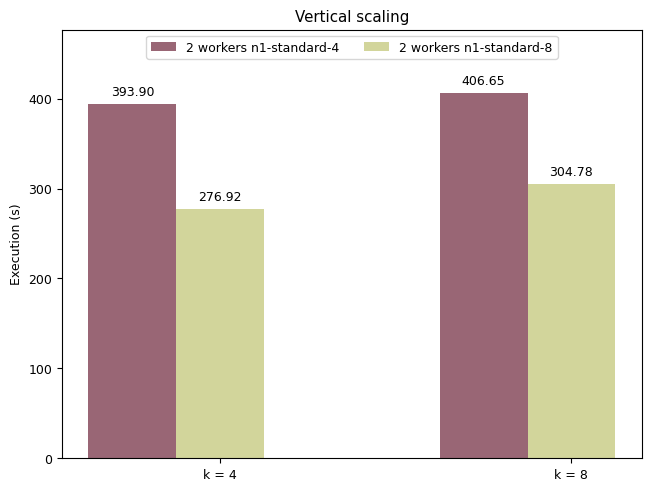

In [113]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os

dir_dr4 = 'plot/vertical/dr4'
dir_dr8 = 'plot/vertical/dr8'

kmers = ("k = 4", "k = 8")
alg_stats = {"2 workers n1-standard-4":(), "2 workers n1-standard-8":()}
times = {'k = 4':[], 'k = 8':[]}

for file in os.listdir(dir_dr4):
  file_path = dir_dr4 + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['k = 4'].append(exeTime)

for file in os.listdir(dir_dr8):
  file_path = dir_dr8 + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['k = 8'].append(exeTime)

alg_stats["2 workers n1-standard-4"] = (times["k = 4"][1],times["k = 8"][1])
alg_stats["2 workers n1-standard-8"] = (times["k = 4"][0],times["k = 8"][0])
# colors = {"5 workers":'#66669e', "4 workers":'#8f8ec9',"3 workers":'#babae0', "2 workers":'#c9cb59', "single node":'#a19830'}
colors = {"2 workers n1-standard-4":'#996675', "2 workers n1-standard-8":'#d2d59b'}


x = np.arange(len(kmers))  #label
width = 0.25
multiplier = 0


fig, ax = plt.subplots(layout='constrained')
plt.rcParams.update({'font.size': 9})

for attribute, measurement in alg_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
    ax.bar_label(rects, padding=4, fmt='%.2f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution (s)')
ax.set_title('Vertical scaling')
ax.set_xticks(x + width, kmers)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, max(times["k = 8"])+70)

plt.show()


Sa questo grafico è possibile vedere come le prestazioni dell'algoritmo distribuito sono comparabili nei casi della ricerca dei kmer di lunghezza differente (4 e 8). Inoltre, l'algoritmo beneficia dell'aumento delle capacità di calcolo dei cluster, che passano da 4 vCPU a 8 vCPu per nodo.


### iii. Creazione del grafico per il ***weak scaling***

Per effettuare una analisi sul weak scaling si mettono a confronto i tempi di cluster differenti su altrettanti dataset, al fine di osservare il comportamento delle esecuzioni distribuite con l'aumento progressivo delle capacità del cluster e della dimensione del file input.

In particolare, le prove svolte sono state effettuate con l'algoritmo **distribuito** per una conta dei kmer di lunghezza 4, su cluster di tipo `n1-standard-4`. I differenti file genomici sono stati testati su cluster con il seguente numero di worker:


*   Saccharomyces cerevisiae (12.1 *M base*) su cluster con **2 worker**;
*   Drosophila melanogaster (143.7 *M base*) su cluster con **3 worker**;
*   Serinus canaria (1.1 *G base*) su cluster con **4 worker**;
*   Mus musculus (2.7 *G base*) su cluster con **5 worker**.



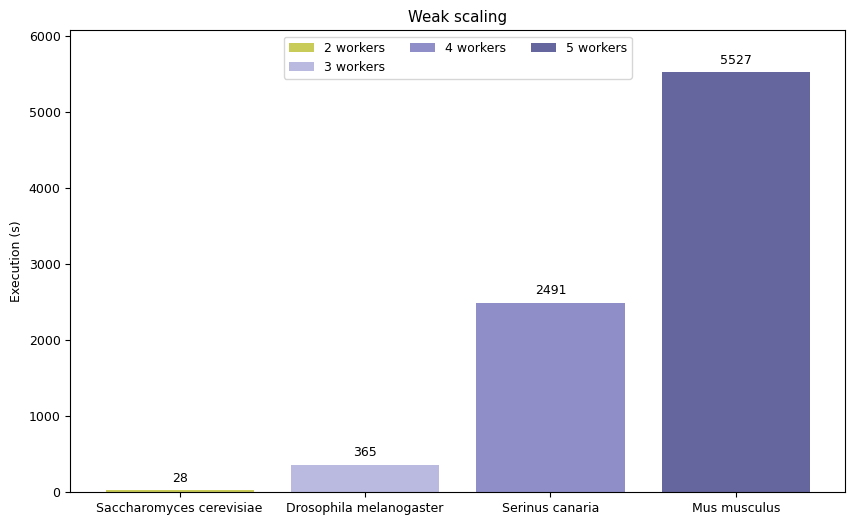

In [112]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os

dir_dist = 'plot/weak'

genome = ("Saccharomyces cerevisiae", "Drosophila melanogaster", "Serinus canaria", "Mus musculus")
alg_stats = []
clusters = ["2 workers", "3 workers", "4 workers", "5 workers"]

with open("plot/weak/two4std-sc-dist_part-00000") as reads:
   alg_stats.append(float(reads.readline().split(',', 1)[0].strip('#').strip()))
with open("plot/weak/three-4standard-d_part-00000") as reads:
  alg_stats.append(float(reads.readline().split(',', 1)[0].strip('#').strip()))
with open("plot/weak/four-4standard-sc_part-00000") as reads:
  alg_stats.append(float(reads.readline().split(',', 1)[0].strip('#').strip()))
with open("plot/weak/five-4standard-mm_part-00000") as reads:
  alg_stats.append(float(reads.readline().split(',', 1)[0].strip('#').strip()))

bar_colors = ['#c9cb59', '#babae0', '#8f8ec9', '#66669e']

fig, ax = plt.subplots(figsize = (10, 6))
rects = ax.bar(genome, alg_stats, label=clusters, color=bar_colors)
ax.bar_label(rects, padding=4, fmt='%.0f')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution (s)')
ax.set_title('Weak scaling')
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, max(alg_stats)+0.1*max(alg_stats))

plt.show()


Da questo grafico può sembrare che l'algoritmo distribuito non beneficia del weak scaling, in quanto i tempi di esecuzione crescono notevolmente, in particolare nel caso di Serinus canaria e Mus musculus.

Tuttavia, questo è probabilmente dovuto alla sbagliata scelta delle coppie *genoma-cluster* testati. Infatti, un più corretto e significativo studio del weak scaling avrebbe confrontato esecuzioni in cui la dimensione del problema rimaneva costante per processore, cosa non valida per gli esempi in esame.

La scelta dei genomi è stata fatta per selezionare organismi frequentemente studiati, ma in questo modo non è stato possibile selezionare il cluster più adatto per ogni genoma a causa delle limitazioni nel numero di CPU utilizzabili.

Concludendo, sebbene questo confronto non sia significativo, in coerenza con gli altri risultati, si suppone che scegliendo cluster di maggiori dimensioni e dalle maggiori capacità sarebbe possibile osservare un notevole miglioramento delle prestazioni.

### iV. Creazione del grafico per il ***strong scaling***

L'analisi dello strong scaling è stato effettuato confrontando i tempi di esecuzione dell'algoritmo **distribuito** su un unico file genomico, al variare della grandezza del cluster.

In particolare, questo è stato svolto per tre differenti casi:


*   conta dei kmer di lunghezza **4** di *Drosophila melanogaster*;
*   conta dei kmer di lunghezza **8** di *Drosophila melanogaster*;
*   conta dei kmer di lunghezza **4** di *Mus musculus*.

Per ognuno dei tre casi riportati, la stessa conta è stata svolta su quatto cluster differenti:


*   custer `n1-standard-4` con 2 worker;
*   custer `n1-standard-4` con 3 worker;
*   custer `n1-standard-4` con 4 worker;
*   custer `n1-standard-4` con 5 worker.





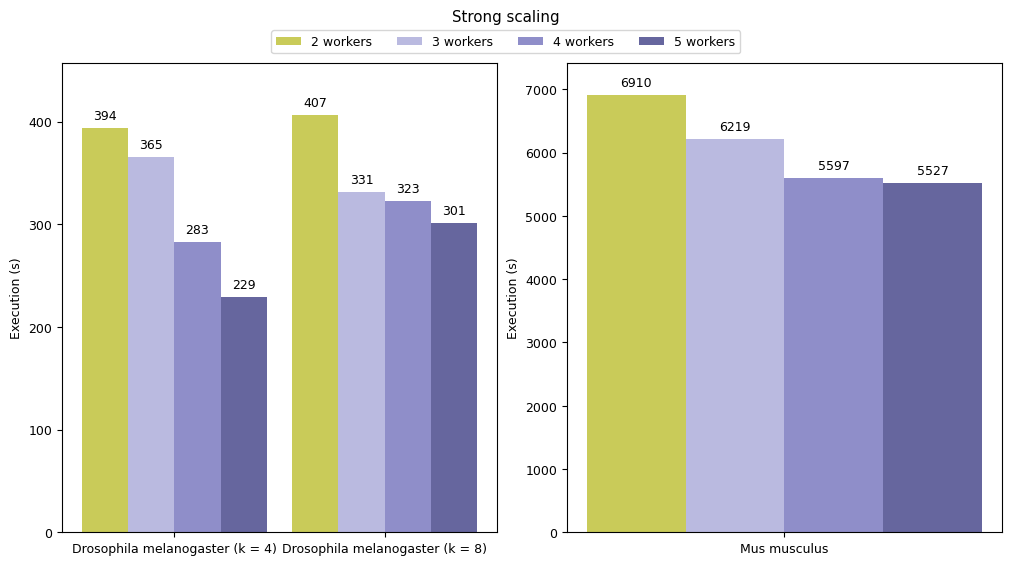

In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os

dir_dr4 = 'plot/strong/dr4'
dir_dr8 = 'plot/strong/dr8'
dir_mm = 'plot/strong/mm'

genome = ("Drosophila melanogaster (k = 4)", "Drosophila melanogaster (k = 8)")
genome_2 = ("Mus musculus",)
alg_stats = {"2 workers":(), "3 workers":(), "4 workers":(), "5 workers":()}
times = {'Drosophila melanogaster (k = 4)':[], 'Drosophila melanogaster (k = 8)':[], 'Mus musculus':[]}

for file in os.listdir(dir_dr4):
  file_path = dir_dr4 + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Drosophila melanogaster (k = 4)'].append(exeTime)

for file in os.listdir(dir_dr8):
  file_path = dir_dr8 + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Drosophila melanogaster (k = 8)'].append(exeTime)

for file in os.listdir(dir_mm):
  file_path = dir_mm + "/" + file
  with open(file_path) as reads:
    exeTime = float(reads.readline().split(',', 1)[0].strip('#').strip())
    times['Mus musculus'].append(exeTime)

alg_stats["2 workers"] = (times[genome[0]][2],times[genome[1]][1])
alg_stats["3 workers"] = (times[genome[0]][0],times[genome[1]][3])
alg_stats["4 workers"] = (times[genome[0]][1],times[genome[1]][2])
alg_stats["5 workers"] = (times[genome[0]][3],times[genome[1]][0])

alg_stats_2 = {"2 workers":(times[genome_2[0]][2],),
               "3 workers":(times[genome_2[0]][0],),
               "4 workers":(times[genome_2[0]][3],),
               "5 workers":(times[genome_2[0]][1],),}

colors = {"5 workers":'#66669e', "4 workers":'#8f8ec9',"3 workers":'#babae0', "2 workers":'#c9cb59', "single node":'#a19830'}


x = np.arange(len(genome))  #label
x1 = np.arange(len(genome_2))  #label
width = 0.22
multiplier = 0


# fig, ax = plt.subplots(layout='constrained')
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(10,5))
plt.rcParams.update({'font.size': 9})

for attribute, measurement in alg_stats.items():
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
    ax1.bar_label(rects, padding=4, fmt='%.0f')
    multiplier += 1

ax1.set_ylabel('Execution (s)')
fig.suptitle('Strong scaling', y=1.1)
ax1.set_xticks(x + width*1.5, genome)
fig.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5,1.07), bbox_transform=fig.transFigure)
ax1.set_ylim(0, max(  times[genome[1]])+50)


ax2.set_ylabel('Execution (s)')
multiplier = 0
for attribute, measurement in alg_stats_2.items():
    offset = width* multiplier
    rects2 = ax2.bar(x1 + offset, measurement, width, label = attribute, color=colors[attribute])
    ax2.bar_label(rects2, padding=4, fmt='%.0f')
    multiplier += 1

# ax2.bar_label(rects, padding=4, fmt='%.0f')
ax2.set_ylim(0, max( times[genome_2[0]])+500)
ax2.set_xticks(x1+width*1.5, genome_2)

plt.show()

#TODO controlla valori perchè sono sicuramente disordinati

Da questo confronto è possibile vedere come l'algoritmo distribuito beneficia dello strong scaling. Le prestazioni delle esecuzioni migliorano, infatti, con l'aumentare della dimensione del cluster.

Il migliore speed-up è osservabile nel caso dell'esecuzione su kmer di lunghezza 4 di Drosophila melanogaster. Nel caso di kmer di lunghezza 8, sebbene le prestazioni non siano dissimili dal caso precedente, è visibile un minore miglioramento nel passaggio da 3, 4 e 5 worker. Questo può essere spiegato osservando l'aumento della complessità per l'estrazione e la memorizzazione di frammenti genomici di lunghezza superiore. Un migliore speed-up si potrebbe osservare selezionando cluster di macchine otimizzate per la memoria.

Infine, coerentemente con quanto evidenziato nel grafico del weak scaling, sebbene sia osservabile uno speed-up anche nel caso di esecuzione sul genoma Mus musculus, un miglioramento di prestazioni così minimale può essere spiegato con le grandi dimensioni del file genomico. Anche in questo caso, cluster più potenti mostrerebbero probabilmente un migliore speed-up.

## 10. Conclusioni

Dalle esecuzioni svolte e dai confronti effettuati nei grafici è possibile affermare che, complessivamente, l'algoritmo di estrazione dei kmer giova dell'approccio map-reduce e dell'esecuzione distribuita.
Miglioramenti più ridotti si hanno in caso di genomi di grandi dimensioni (come Mus musculus), per i quali sarebbe necessario l'utilizzo di cluster più complessi.

Per genomi di piccole dimensioni, come il Saccharomyces cerevisiae, l'algoritmo parallelo è più indicato, mentre per genomi più grandi risulta inutilizzabile (esattamente come la versione di libreria).